# Solving the Black-Scholes Equation Using Physics-Informed Neural Networks (PINNs)

## Introduction

The Black-Scholes equation is a fundamental partial differential equation (PDE) in financial mathematics used to model the price of European options. It is given by:

$$
\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + r S \frac{\partial V}{\partial S} - r V = 0
$$

Where:

- $V(S, t)$ is the option price as a function of the stock price $S$ and time $t$.
- $\sigma$ is the volatility of the underlying asset.
- $r$ is the risk-free interest rate.
- $T$ is the time to maturity.
- $K$ is the strike price of the option.

The goal is to find $V(S, t)$ satisfying this PDE with appropriate boundary and initial conditions.

## Physics-Informed Neural Networks (PINNs)

PINNs incorporate the PDE and boundary conditions into the loss function of a neural network. The network learns a function $V_\theta(S, t)$, parameterized by weights $\theta$, that approximates the solution of the PDE.

## Loss Function Components

1. **PDE Residual Loss:**

   $$
   \text{Loss}_{\text{PDE}} = \frac{1}{N_t} \sum_{i=1}^{N_t} \left| \frac{\partial V_\theta}{\partial t} + \frac{1}{2} \sigma^2 S_i^2 \frac{\partial^2 V_\theta}{\partial S^2} + r S_i \frac{\partial V_\theta}{\partial S} - r V_\theta \right|^2
   $$

2. **Boundary and Initial Condition Loss:**

   $$
   \text{Loss}_{\text{BC/IC}} = \frac{1}{N_b} \sum_{i=1}^{N_b} \left| V_\theta(S_i, t_i) - V_{\text{exact}}(S_i, t_i) \right|^2
   $$

## Total Loss

$$
\text{Loss} = \text{Loss}_{\text{PDE}} + \text{Loss}_{\text{BC/IC}}
$$


Epoch 0, Loss: 449.4983215332031
Epoch 500, Loss: 137.7984161376953
Epoch 1000, Loss: 61.519954681396484
Epoch 1500, Loss: 28.721923828125
Epoch 2000, Loss: 13.796672821044922
Epoch 2500, Loss: 6.814243316650391
Epoch 3000, Loss: 3.465787887573242
Epoch 3500, Loss: 1.8143984079360962
Epoch 4000, Loss: 0.9891175031661987
Epoch 4500, Loss: 0.5686284303665161


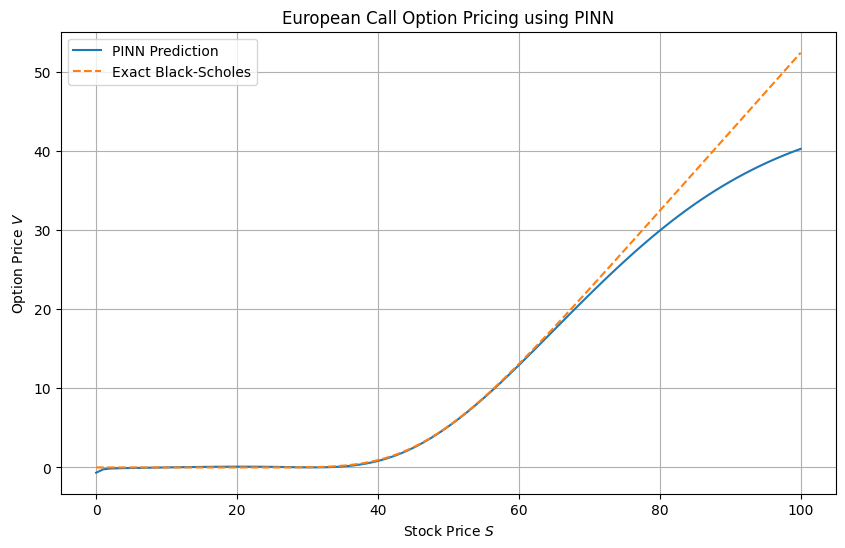

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Parameters
sigma = 0.2   # Volatility
r = 0.05      # Risk-free interest rate
K = 50        # Strike price
T = 1.0       # Time to maturity

# Neural network model
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layers = [
            tf.keras.layers.Dense(20, activation='tanh') for _ in range(3)
        ]
        self.output_layer = tf.keras.layers.Dense(1, activation=None)

    def call(self, S, t):
        X = tf.concat([S, t], axis=1)
        for layer in self.hidden_layers:
            X = layer(X)
        V = self.output_layer(X)
        return V

# Define the loss function
def loss_function(model, S_f, t_f, S_b, t_b):
    # PDE Residual Loss
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([S_f, t_f])
        V_f = model(S_f, t_f)
        V_t = tape.gradient(V_f, t_f)
        V_S = tape.gradient(V_f, S_f)
    V_SS = tape.gradient(V_S, S_f)
    del tape
    residual = V_t + 0.5 * sigma**2 * S_f**2 * V_SS + r * S_f * V_S - r * V_f
    loss_pde = tf.reduce_mean(tf.square(residual))

    # Boundary and Initial Condition Loss
    V_b_pred = model(S_b, t_b)
    V_b_exact = tf.maximum(S_b - K, 0)  # Payoff for a call option at maturity
    loss_bc = tf.reduce_mean(tf.square(V_b_pred - V_b_exact))

    # Total Loss
    loss = loss_pde + loss_bc
    return loss

# Training data
N_f = 10000  # Number of PDE collocation points
N_b = 2000   # Number of boundary points

# Sampling S and t for PDE residual
S_f = tf.random.uniform((N_f, 1), minval=0.0, maxval=2*K)
t_f = tf.random.uniform((N_f, 1), minval=0.0, maxval=T)

# Sampling S and t for boundary conditions (at t = T)
S_b = tf.linspace(0.0, 2*K, N_b)[:, None]
t_b = T * tf.ones_like(S_b)

# Initialize model
model = PINN()

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training loop
epochs = 5000

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        loss = loss_function(model, S_f, t_f, S_b, t_b)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

# Testing the model
S_test = np.linspace(0.0, 2*K, 100).reshape(-1, 1)
t_test = np.zeros_like(S_test)
V_pred = model(tf.constant(S_test, dtype=tf.float32), tf.constant(t_test, dtype=tf.float32))
V_pred = V_pred.numpy().flatten()

# Exact Black-Scholes solution at t=0 for a European call option
def black_scholes_call(S, K, T, r, sigma):
    from scipy.stats import norm
    S = np.maximum(S, 1e-8)  # Avoid division by zero
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call

V_exact = black_scholes_call(S_test.flatten(), K, T - t_test.flatten(), r, sigma)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(S_test, V_pred, label='PINN Prediction')
plt.plot(S_test, V_exact, label='Exact Black-Scholes', linestyle='--')
plt.xlabel('Stock Price $S$')
plt.ylabel('Option Price $V$')
plt.title('European Call Option Pricing using PINN')
plt.legend()
plt.grid(True)
plt.show()


## Nvidia Stock price: NVDA (NASDAQ) from Yahoo Finance

Date          Closing Price (S)
Oct 31, 2024    $137.60
Oct 30, 2024    $139.54
Oct 29, 2024    $140.29
Oct 28, 2024    $143.00
Oct 25, 2024    $140.93
Oct 24, 2024    $140.82
Oct 23, 2024    $142.03
Oct 22, 2024    $142.91
Oct 21, 2024    $138.13
Oct 18, 2024    $138.67
Oct 17, 2024    $139.34
Oct 16, 2024    $133.98
Oct 15, 2024    $137.87
Oct 14, 2024    $136.47
Oct 11, 2024    $134.01
Oct 10, 2024    $131.91
Oct 9, 2024     $134.11
Oct 8, 2024     $130.26
Oct 7, 2024     $124.99
Oct 4, 2024     $124.94
Oct 3, 2024     $120.92
Oct 2, 2024     $116.44
Oct 1, 2024     $121.77

    Stock Price  PINN Predicted Option Price  Exact Black-Scholes Option Price
0        137.60                    45.716263                          9.539401
1        139.54                    45.806545                         11.067702
2        140.29                    45.839226                         11.681861
3        143.00                    45.947945                         13.994399
4        140.93                    45.866188                         12.215343
5        140.82                    45.861614                         12.123057
6        142.03                    45.910641                         13.151083
7        142.91                    45.944557                         13.915481
8        138.13                    45.741787                          9.947808
9        138.67                    45.767117                         10.371120
10       139.34                    45.797626                         10.906024
11       133.98                    45.522854        

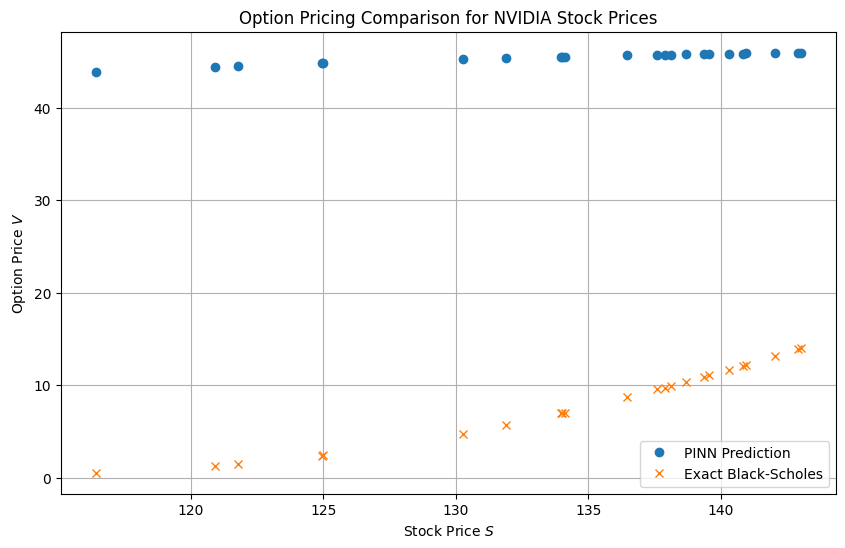

In [12]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Updated Parameters
sigma = 0.30   # Updated volatility
r = 0.02       # Updated risk-free interest rate
K = 130        # Updated strike price
T = 1/12       # Time to maturity (1 month)

# NVIDIA's October 2024 closing prices
nvidia_prices = [
    137.60, 139.54, 140.29, 143.00, 140.93,
    140.82, 142.03, 142.91, 138.13, 138.67,
    139.34, 133.98, 137.87, 136.47, 134.01,
    131.91, 134.11, 130.26, 124.99, 124.94,
    120.92, 116.44, 121.77
]

# Convert prices to a NumPy array
S_test = np.array(nvidia_prices).reshape(-1, 1)
t_test = np.zeros_like(S_test)  # Assuming we're pricing the options today

# Ensure the model is trained with the updated parameters
# If not, retrain the model with the updated sigma, r, K, and T

# Convert test data to TensorFlow constants
S_test_tf = tf.constant(S_test, dtype=tf.float32)
t_test_tf = tf.constant(t_test, dtype=tf.float32)

# Predict option prices using the PINN model
V_pred = model(S_test_tf, t_test_tf).numpy().flatten()

# Compute exact option prices
def black_scholes_call(S, K, T, r, sigma):
    from scipy.stats import norm
    S = np.maximum(S, 1e-8)  # Avoid division by zero
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call

V_exact = black_scholes_call(S_test.flatten(), K, T - t_test.flatten(), r, sigma)

# Create a DataFrame for better visualization
results_df = pd.DataFrame({
    'Stock Price': S_test.flatten(),
    'PINN Predicted Option Price': V_pred,
    'Exact Black-Scholes Option Price': V_exact
})

# Print the results
print(results_df)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(S_test.flatten(), V_pred, 'o', label='PINN Prediction')
plt.plot(S_test.flatten(), V_exact, 'x', label='Exact Black-Scholes')
plt.xlabel('Stock Price $S$')
plt.ylabel('Option Price $V$')
plt.title('Option Pricing Comparison for NVIDIA Stock Prices')
plt.legend()
plt.grid(True)
plt.show()


## If the stock price is 140 and the strike price is 130, the value of the call option is 10 (140 - 130)